In [1]:
import torch
import sys


torch.set_default_dtype(torch.float64)

sys.path.append('../Packages')
from torch.utils.data import DataLoader, Dataset
from skimage import data, filters
from tqdm.notebook import tqdm as tqdm
from model import *
from plot import *
import os
import algo.geodesic as geo
import algo.euler as euler

from matplotlib import pyplot as plt
from disp.vis import *
from util import riemann, tensors, diff
from pathlib import Path

%matplotlib inline

/home/pits/Documents/MVA/geometric_data_analysis/Metric-Cnn-2D-IPMI/Scripts/../Packages/disp/vis.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if hasattr(np, 'bool'):


In [2]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, field1, field2):
        self.data_dir = data_dir
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        vector_field1_path = self.data_dir / 'sin' / 'sin_vector_field.nhdr'
        mask1_path = self.data_dir / 'sin' / 'sin_filt_mask.nhdr'
        vector_field1 = field1.permute(2,0,1).to(device).float()*1000.0
        mask1 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(mask1_path))).permute(1,0)
        boundary_mask1 = torch.where(torch.from_numpy(filters.laplace(mask1.cpu().numpy()))>0,1,0)
        mask1 = (mask1-boundary_mask1).float().to(device)

        vector_field2_path = self.data_dir / 'cos' / 'cos_vector_field.nhdr'
        mask2_path = self.data_dir / 'cos' / 'cos_filt_mask.nhdr'
        vector_field2 = field2.permute(2,0,1).to(device).float()*1000.0
        mask2 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(mask2_path))).permute(1,0)
        boundary_mask2 = torch.where(torch.from_numpy(filters.laplace(mask2.cpu().numpy()))>0,1,0)
        mask2 = (mask2-boundary_mask2).float().to(device)

        self.sample = {  'vector_field'  : torch.cat((vector_field1,vector_field2),0),
                    'mask1'          : mask1.unsqueeze(0),
                    'mask2'          : mask2.unsqueeze(0)}

    def __len__(self):
        return 1

    def __getitem__(self, idx):

        return self.sample

def matrix_exp_2d(A):
    """
    Construct positive definite matrix from symmetric matrix field A
    Args:
        A, torch.Tensor
    Returns:
        psd, torch.Tensor
    """
    I = torch.zeros_like(A, device='cpu')
    I[...,0,0] = 1
    I[...,1,1] = 1

    s = ((A[...,0,0]+A[...,1,1])/2.).unsqueeze(-1).unsqueeze(-1)
    q = torch.sqrt(-torch.det(A-torch.mul(s, I))).unsqueeze(-1).unsqueeze(-1)

    psd = torch.exp(s)*(torch.mul((torch.cosh(q)-s*torch.sinh(q)/q),I)+torch.sinh(q)/q*A)
    return psd

def pde(u, vector_lin, mask, differential_accuracy=2):
    s = tensors.lin2mat(u)
    metric_mat = matrix_exp_2d(s)
    nabla_vv = riemann.covariant_derivative_2d(vector_lin, metric_mat, mask, differential_accuracy=differential_accuracy)

    return nabla_vv

In [3]:
mode='cpu'
device = torch.device('cpu')
torch.set_default_dtype(torch.float64)

### [Matrix exponential for 2D](https://en.wikipedia.org/wiki/Matrix_exponential)
${\displaystyle e^{tA}=e^{st}\left(\left(\cosh(qt)-s{\frac {\sinh(qt)}{q}}\right)~I~+{\frac {\sinh(qt)}{q}}A\right)~.}$ where $t=1$, $s=tr({A}/2), q=-\sqrt{-\det(A-sI)}$

In [4]:
input_dir = '../Brains'
output_dir = f'../Checkpoints/braid'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

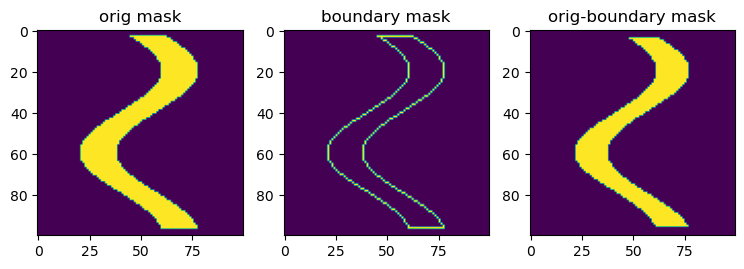

In [5]:
name = 'sin'
mask1 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{name}/{name}_filt_mask.nhdr'))).double().permute(1,0)
height, width = mask1.shape[0], mask1.shape[1]
x_range = (0, height-1)
y_range = (0, width-1)
boundary_mask = torch.where(torch.from_numpy(filters.laplace(mask1.cpu().numpy()))>0,1,0)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(mask1.numpy())
ax1.set_title('orig mask')
ax2.imshow(boundary_mask.numpy())
ax2.set_title('boundary mask')
mask1 = mask1-boundary_mask
ax3.imshow(mask1.numpy())
ax3.set_title('orig-boundary mask')

plt.show()

mask1 = mask1.to(device)

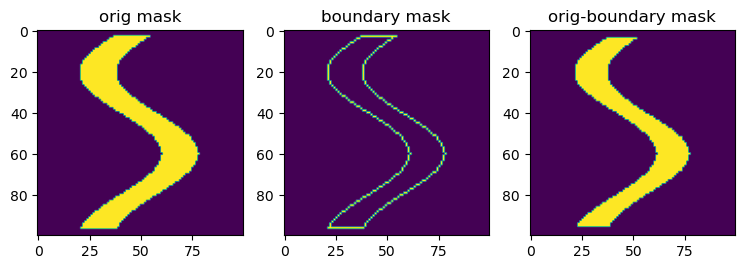

In [6]:
name = 'cos'
mask2 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{name}/{name}_filt_mask.nhdr'))).double().permute(1,0)
height, width = mask2.shape[0], mask2.shape[1]
x_range = (0, height-1)
y_range = (0, width-1)
boundary_mask = torch.where(torch.from_numpy(filters.laplace(mask2.cpu().numpy()))>0,1,0)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(mask2.numpy())
ax1.set_title('orig mask')
ax2.imshow(boundary_mask.numpy())
ax2.set_title('boundary mask')
mask2 = mask2-boundary_mask
ax3.imshow(mask2.numpy())
ax3.set_title('orig-boundary mask')

plt.show()

mask2 = mask2.to(device)

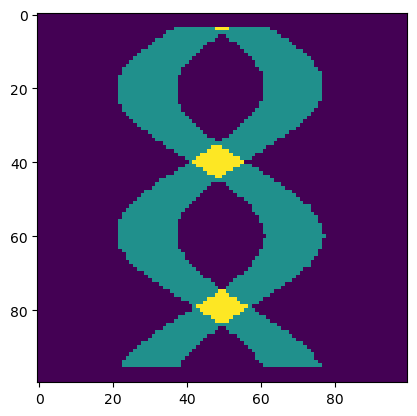

In [7]:
plt.imshow((mask1+mask2).cpu().numpy())

In [8]:
field1 = np.zeros((height, width, 2))
field2 = np.zeros((height, width, 2))

for x in range(0, width):
    for k in range(0,15,2):
        y1 = int(20 * np.sin(1 / (4 * np.pi) * x) + 41 + k)
        y2 = int(20 * np.cos(1 / (4 * np.pi) * (x-60)) + 41 + k)
        field1[x, y1, :] = np.array([1, 1 / (4 * np.pi) * 20 * np.cos(1 / (4 * np.pi) * x)])
        field2[x, y2, :] = np.array([1, -1 / (4 * np.pi) * 20 * np.sin(1 / (4 * np.pi) * (x - 60))])

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1645461915109/work/aten/src/ATen/native/TensorShape.cpp:2156.)


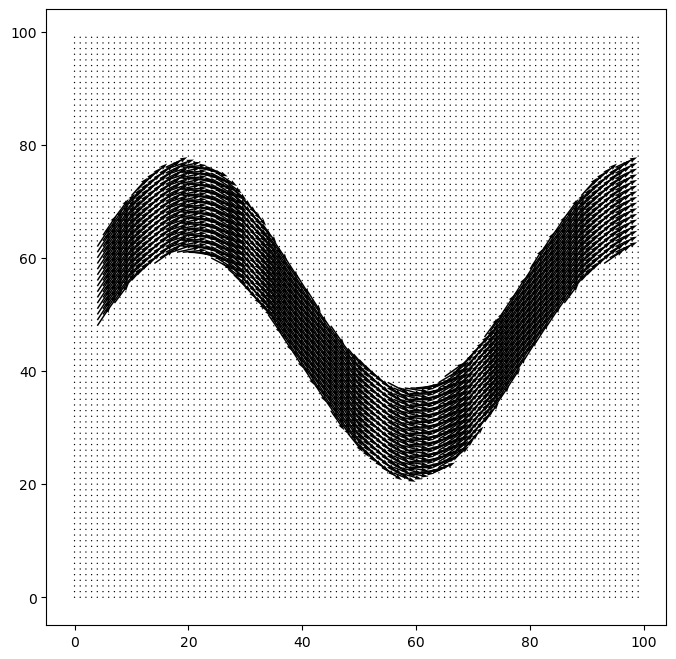

In [9]:
name = 'sin'
vector_field1 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{name}/{name}_vector_field.nhdr'))).to(device)
x = torch.linspace(0,height-1,height)
y = torch.linspace(0,width-1,width)
xx, yy = torch.meshgrid(x,y)
plt.figure(figsize=(8,8))
plt.quiver(xx.cpu(),yy.cpu(),vector_field1[:,:,0].cpu().numpy()*mask1.cpu().numpy(),vector_field1[:,:,1].cpu().numpy()*mask1.cpu().numpy())
X = x.cpu().numpy()

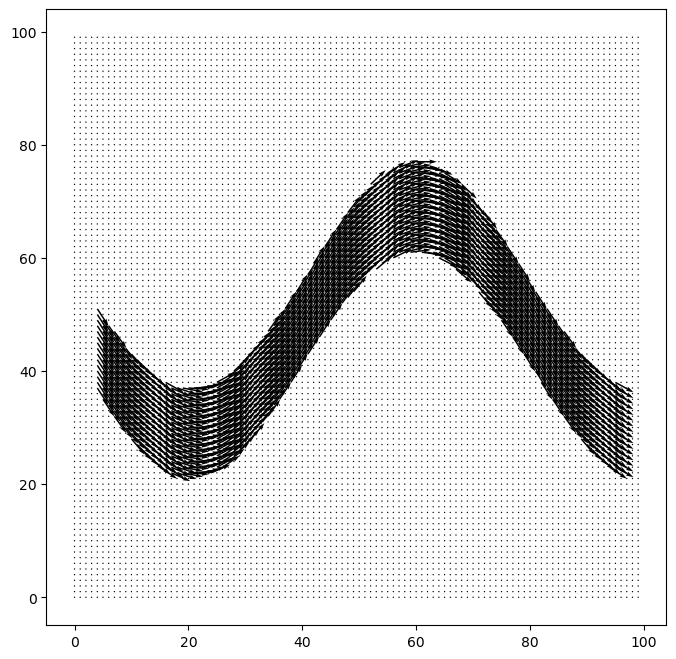

In [10]:
name = 'cos'
vector_field2 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/{name}/{name}_vector_field.nhdr'))).to(device)
x = torch.linspace(0,height-1,height)
y = torch.linspace(0,width-1,width)
xx, yy = torch.meshgrid(x,y)
plt.figure(figsize=(8,8))
plt.quiver(xx.cpu(),yy.cpu(),vector_field2[:,:,0].cpu().numpy()*mask2.cpu().numpy(),vector_field2[:,:,1].cpu().numpy()*mask2.cpu().numpy(),scale=3e1)

# Training

In [39]:
epoch_loss_list = []
epoch_num = 1001
start_epoch_num = 0
learning_rate = 1e-2

model = DenseED(
    in_channels=4,
    out_channels=3,
    imsize=100,
    blocks=[6, 8, 6],
    growth_rate=16,
    init_features=48,
    drop_rate=0,
    out_activation=None,
    upsample='nearest'
)
model.train()

criterion = torch.nn.MSELoss()
optimizer_id = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

dataset_id = ImageDataset(Path(input_dir), vector_field1, vector_field2)

dataloader_id = DataLoader(dataset_id, batch_size=1, shuffle=True, num_workers=0)

# params 747147, # conv layers 28


In [40]:
model = model.float()
for epoch in tqdm(range(start_epoch_num, start_epoch_num+epoch_num)):
    epoch_loss_id = 0
    epoch_loss_bd = 0
            
    for i, batched_id_sample in enumerate(dataloader_id):
        '''innerdomain backpropagate'''
        input_id = batched_id_sample['vector_field'].to(device).float()
        input_id.requires_grad = True
        # u_pred_id: [batch_size, *data_shape, feature_num] = [1, 3, ...]
        u_pred_id = model(input_id)
        # f_pred_id: [batch_size, feature_num, *data_shape] = [1, 2, ...]
        mask1 = batched_id_sample['mask1'].squeeze()
        mask2 = batched_id_sample['mask2'].squeeze()
        pde_loss1 = pde(u_pred_id.squeeze().double(), input_id[0,:2].squeeze().double(), mask1, differential_accuracy=2)
        pde_loss2 = pde(u_pred_id.squeeze().double(), input_id[0,2:].squeeze().double(), mask2, differential_accuracy=2)
        f_pred_1 = torch.einsum('...ij,...ij->...ij', pde_loss1, mask1.unsqueeze(0).expand(2,-1,-1))
        f_pred_2 = torch.einsum('...ij,...ij->...ij', pde_loss2, mask2.unsqueeze(0).expand(2,-1,-1))
        f_pred_id = torch.cat((f_pred_1,f_pred_2),0)
        # f_true_id: [batch_size, feature_num, *data_shape] = [1, 2, ...]
        f_true_id = torch.zeros_like(f_pred_id)
    
        optimizer_id.zero_grad()
        loss_id = criterion(f_pred_id, f_true_id)
        loss_id.backward()
        epoch_loss_id += loss_id.item()
        optimizer_id.step()
        
    with open(f'{output_dir}/loss.txt', 'a') as f:
        f.write(f'{epoch_loss_id}\n')
    
    epoch_loss_list.append(epoch_loss_id)
    if epoch%10==0:       
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_id_state_dict': optimizer_id.state_dict(),
        'loss_id': epoch_loss_id
        }, f'{output_dir}/model.pth.tar')

  0%|          | 0/1001 [00:00<?, ?it/s]

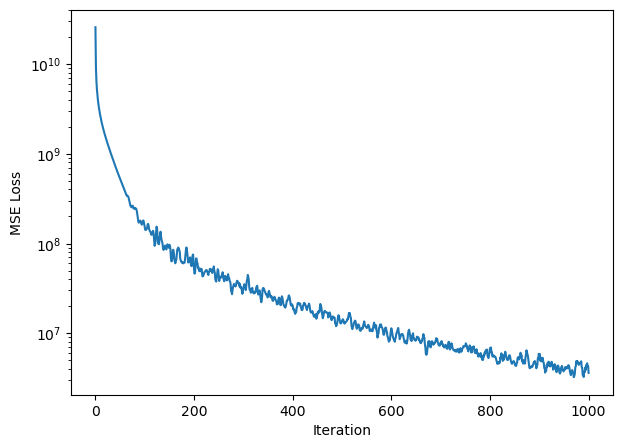

In [41]:
_, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Iteration')
ax.set_ylabel('MSE Loss')
ax.set_yscale('log')
ax.plot(epoch_loss_list)
plt.savefig(f'{output_dir}/adadelta_loss_{learning_rate}.png')

# Plotting

In [42]:
checkpoint = torch.load(f'{output_dir}/model.pth.tar')

model.load_state_dict(checkpoint['model_state_dict'])



mask = torch.where(mask1+mask2>0,1,0)
model = model.float()
u_pred = model(torch.cat((vector_field1.permute(2,0,1).unsqueeze(0).float(),vector_field2.to(device).permute(2,0,1).unsqueeze(0).float()),1))
u_pred = u_pred.squeeze()
s_pred = tensors.lin2mat(u_pred)

metric_pred_mat = matrix_exp_2d(s_pred)
metric_pred_lin = tensors.mat2lin(metric_pred_mat)

In [43]:
name = 'braid'
input_dir = '../Brains'
output_dir = f'../Checkpoints/{name}'

epoch = 2000

vector_lin1 = vector_field1.permute(2,0,1).numpy()
vector_lin2 = vector_field2.permute(2,0,1).numpy()
tensor_pred_mat = np.linalg.inv(metric_pred_mat.detach().numpy())
tensor_pred_lin = tensors.mat2lin(tensor_pred_mat)

In [44]:


geo_delta_t, euler_delta_t = 5e-3, 5e-3
geo_iters, euler_iters = int(1e6), int(1e6)



In [45]:
start_coords = np.array([60,29])
init_velocities = vector_lin1[:,start_coords[0],start_coords[1]]
geox_pred1, geoy_pred1 = geo.geodesicpath('f', tensor_pred_lin , vector_lin1, mask,\
                                                      start_coords, init_velocities, \
                                                      geo_delta_t, iter_num=geo_iters, both_directions=True)

eulx1, euly1 = euler.eulerpath_vectbase_2d_w_dv(vector_lin1, mask, start_coords, euler_delta_t, iter_num=euler_iters, both_directions=True)


Shooting geodesic path from [60 29] with initial velocity [-0.99513281 -0.0985428 ]
Shooting geodesic path from [60 29] with initial velocity [0.99513281 0.0985428 ]
Euler starting eigenvector: [-0.99513281 -0.0985428 ]
Euler starting eigenvector: [0.99513281 0.0985428 ]


In [46]:
start_coords = np.array([60,70])
init_velocities = vector_lin2[:,start_coords[0],start_coords[1]]
geox_pred2, geoy_pred2 = geo.geodesicpath('f', tensor_pred_lin, vector_lin2, mask, start_coords, init_velocities, geo_delta_t, iter_num=geo_iters, both_directions=True)
eulx2, euly2 = euler.eulerpath_vectbase_2d_w_dv(vector_lin2, mask, start_coords, euler_delta_t, iter_num=euler_iters, both_directions=True)

Shooting geodesic path from [60 70] with initial velocity [-1.  0.]
Shooting geodesic path from [60 70] with initial velocity [ 1. -0.]
Euler starting eigenvector: [-1.  0.]
Euler starting eigenvector: [ 1. -0.]


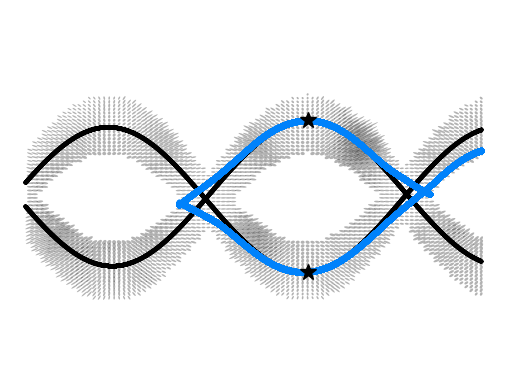

In [47]:

def disp_path(ax, x, y, label, color, size, alpha):
      ax.scatter(x[::1], y[::1], c=color, s=size, alpha=alpha, label=label,zorder=1)

# Convert the mask to a NumPy array if it wasn't already
fig, ax = plt.subplots()
tens_fig = vis_tensors(metric_pred_lin.cpu().detach().numpy() * np.stack((mask, mask, mask), 0), '', False, scale=8e-1, opacity=0.3, show_axis_labels=False, ax=ax)
disp_path(ax, eulx1, euly1, label="integral curve on vector field", color='black', size=2, alpha=1)
disp_path(ax, eulx2, euly2, label="integral curve on vector field", color='black', size=2, alpha=1)
disp_path(ax, geox_pred1, geoy_pred1, label=f"geodesic on learned {name}", color='#0082fb', size=10, alpha=1)
disp_path(ax, geox_pred2, geoy_pred2, label=f"geodesic on learned {name}", color='#0082fb', size=10, alpha=1)


plt.axis('off')
plt.plot([60,60], [29,70], linestyle='', marker='*', color='black', markersize=12)
